# Test tiger with simple linear regression

In [1]:
import jax
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# set path such that interpreter finds tigerpy
import sys
sys.path.append("..")

import tigerpy.model as tiger 
import tigerpy.bbvi as bbvi

# Use distributions from tensorflow probability
import tensorflow_probability.substrates.jax.distributions as tfd

rng = np.random.default_rng(42)

## Simulate data

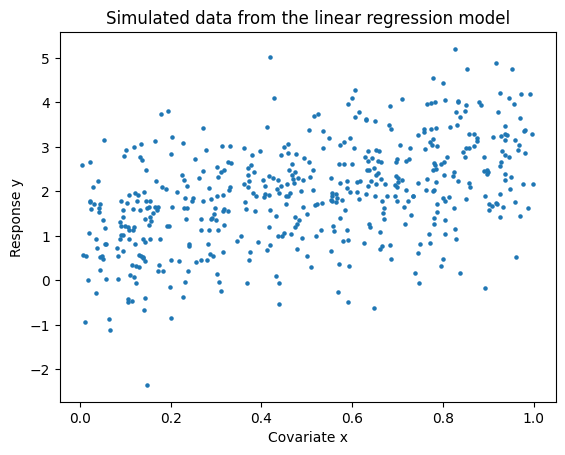

In [2]:
# sample size and true parameters

n = 500
true_beta = np.array([1.0, 2.0])
true_sigma = 1.0

# data-generating process

x0 = rng.uniform(size=n)
X_mat = np.column_stack([np.ones(n), x0])
eps = rng.normal(scale=true_sigma, size=n)
y_vec = X_mat @ true_beta + eps

# plot the simulated data

plt.scatter(x0, y_vec, s = 5)
plt.title("Simulated data from the linear regression model")
plt.xlabel("Covariate x")
plt.ylabel("Response y")
plt.show()

## Set up model in tigerpy

In [3]:
# set up design matrix 
X = tiger.Obs(name = "X")
X.fixed(data = x0)

# set up hyperparameters
beta_loc = tiger.Hyper(0, name="beta_loc")
beta_scale = tiger.Hyper(100, name="beta_scale")

# set up parameters
beta_dist = tiger.Dist(tfd.Normal, loc=beta_loc, scale=beta_scale)
beta = tiger.Param(value=np.array([0.0, 0.0]), distribution=beta_dist, name="beta")

# set up hyperparameters for the scale
sigma_a = tiger.Hyper(0.01, name="a")
sigma_b = tiger.Hyper(0.01, name="b")

sigma_dist = tiger.Dist(tfd.InverseGamma, concentration=sigma_a, scale=sigma_b)
sigma = tiger.Param(value=10.0, distribution=sigma_dist, function=jnp.exp, name="sigma")

# set up the linear predictor
lpred = tiger.Lpred(Obs=X, beta=beta)

# set up response distribution
y_dist = tiger.Dist(tfd.Normal, loc=lpred, scale=sigma)
m = tiger.Model(y=y_vec, distribution=y_dist)

In [4]:
# build the model tree
m.build_tree()

In [5]:
jnp.sum(m.log_lik)

Array(-1623.414, dtype=float32)

In [6]:
m.log_prior

Array([-18.020359], dtype=float32)

In [7]:
m.log_prob

Array([-1641.4343], dtype=float32)

In [8]:
sample = dict(beta=jnp.array([0,0], dtype=jnp.float32), scale=jnp.array([1], dtype=jnp.float32))

m.update_graph(sample=sample)

Array([-1740.374], dtype=float32)

In [9]:
jnp.sum(m.log_lik)

Array(-1724.6703, dtype=float32)

In [10]:
m.log_prior

Array([-15.703748], dtype=float32)

In [11]:
graph = tiger.ModelGraph(Model=m)
graph.build_graph()

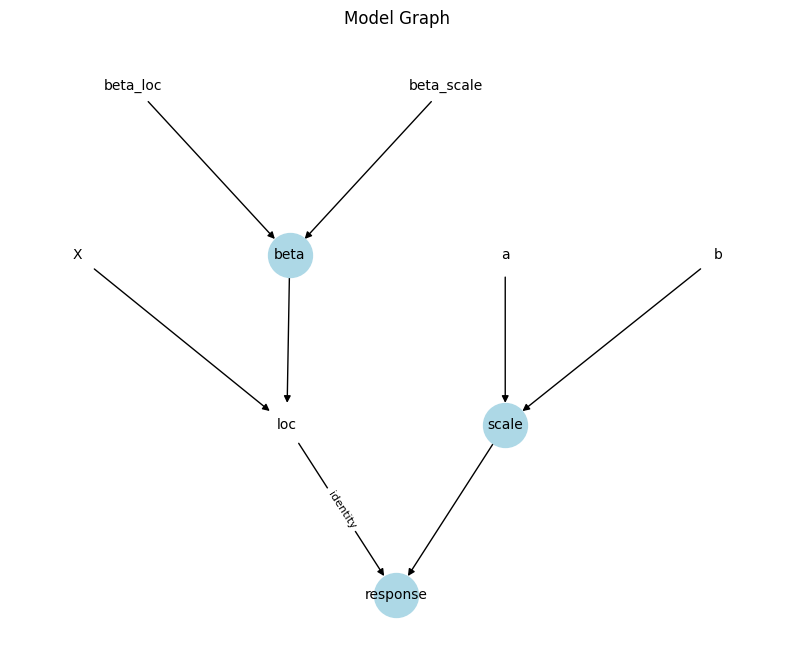

In [12]:
graph.visualize_graph()

## Inference with BBVI

In [13]:
key = jax.random.PRNGKey(27)

q = bbvi.Bbvi(Model=m, num_samples=64, num_iterations=5000, seed=key)

In [16]:
q.run_bbvi(step_size=0.01)

(Array(739.46625, dtype=float32),
 {'beta': {'mu': Array([0.9800668, 1.9156284], dtype=float32),
   'cov': Array([[ 0.0095312 , -0.01582457],
          [-0.01582457,  0.0345134 ]], dtype=float32)},
  'scale': {'mu': Array([0.02605121], dtype=float32),
   'cov': Array([[0.00089746]], dtype=float32)}})

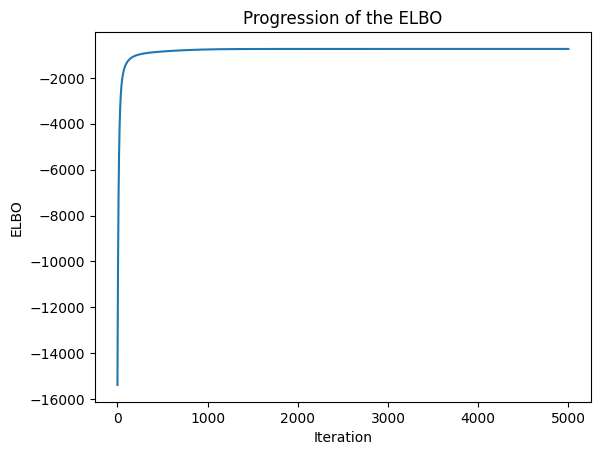

In [15]:
q.plot_elbo()